# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [11]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy


from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_test_image
from arl.fourier_transforms.ftprocessor import *

from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW core configuration

In [12]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [13]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 13695 rows, 0.001 GB
create_visibility: 13695 rows, 0.001 GB


Plot the synthesized uv coverage.

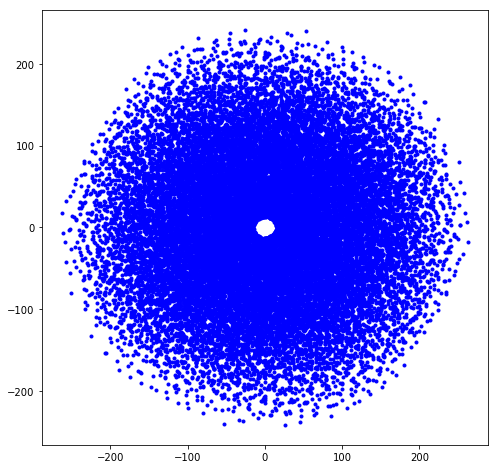

In [14]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: created image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)


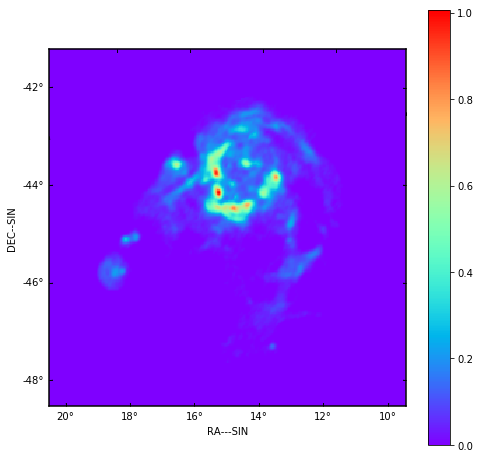

In [15]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

predict_2d: predict using 2d transform
predict_2d: predict using 2d transform


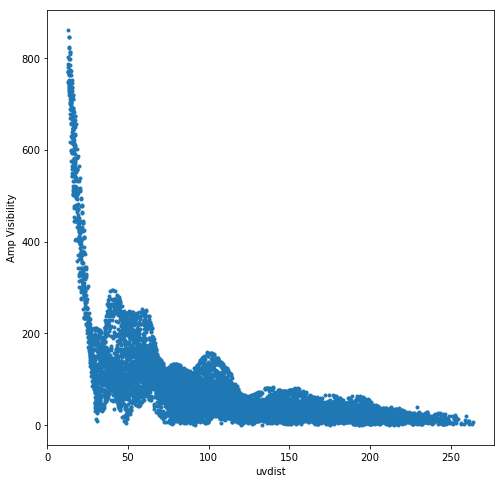

In [16]:
vt = predict_2d(vt, m31image)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d tr

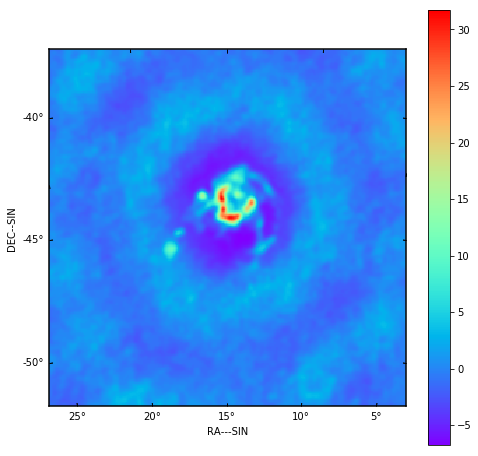

In [17]:
model = create_image_from_visibility(vt, cellsize=0.001, npixel=256)
dirty, sumwt = invert_2d(vt, model)
psf, sumwt = invert_2d(vt, model, dopsf=True)
dirty.data = dirty.data/sumwt
psf.data = psf.data/sumwt

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube: Processing pol 0, channel 0
deconvolve_cube: Processing pol 0, channel 0
msclean: Peak of PSF = 1.0 at (128, 128)
msclean: Peak of PSF = 1.0 at (128, 128)
msclean: Peak of Dirty = 31.6861814289 at (148, 123)
msclean: Peak of Dirty = 31.6861814289 at (148, 123)
msclean: Coupling matrix =
 [[ 1.          0.96212636  0.57597563  0.11587394]
 [ 0.96212636  0.92658832  0.5617779   0.11527677]
 [ 0.57597563  0.5617779   0.39982619  0.10675899]
 [ 0.11587394  0.11527677  0.10675899  0.06262409]]
msclean: Coupling matrix =
 [[ 1.          0.96212636  0.57597563  0.11587394]
 [ 0.96212636  0.92658832  0.5617779   0.11527677]
 [ 0.57597563  0.5617779   0.39982619  0.10675899]
 [ 0.11587394  0.11527677  0.10675899  0.06262409]]
msclean: Max abs in dirty Image = 31.686181
msclean: Max abs in dirty Image = 31.686181
msclean: Start of minor cycle
msclean: Start of minor cycle
msclean: This minor cycle will stop at 100 iterations or peak < 0.316861814289
msclean: This minor cycle wil

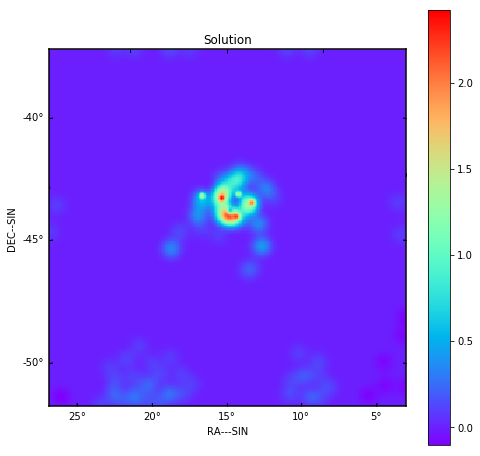

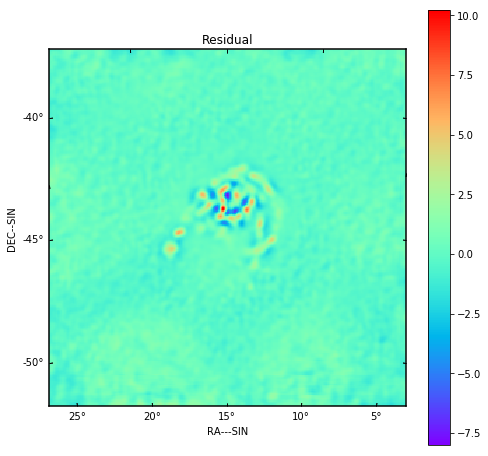

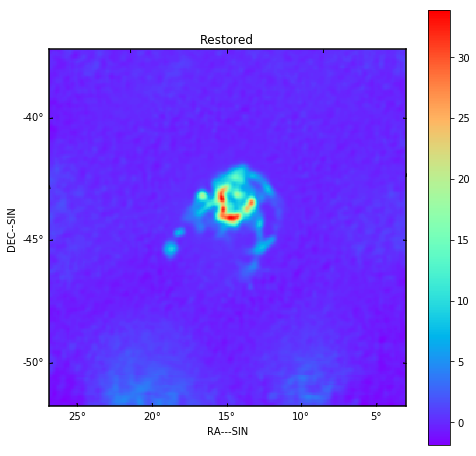

In [18]:
comp, residual = deconvolve_cube(dirty, psf, niter=100, threshold=0.001, fracthresh=0.01, 
                                 scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [19]:
vtmodel = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_2d(vtmodel, comp)

create_visibility: 13695 rows, 0.001 GB
create_visibility: 13695 rows, 0.001 GB
predict_2d: predict using 2d transform
predict_2d: predict using 2d transform


Now we will plot the original visibility and the residual visibility.

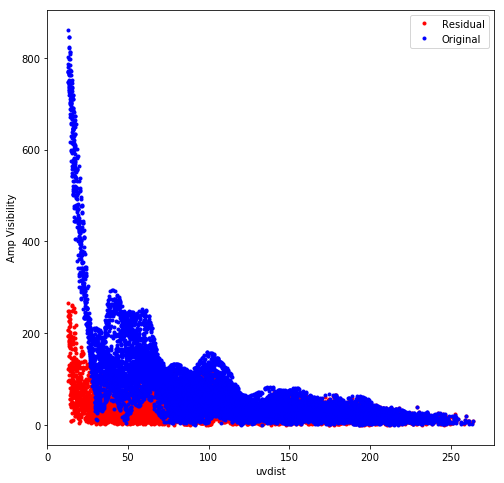

In [20]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()